# **AIRI Tutorial**
# Imaging with AIRI in Python
## Description

AI for Regularization in Imaging, dubbed `AIRI`, is a Plug-and-Play (PnP) algorithm solving inverse imaging problems in **r**adio **i**nterferometry (**RI**) [1]. By inserting carefully trained deep neural network (DNN) as a denoiser  into the proximal splitting algorithms, one waives the computational complexity of optimisation algorithms induced by sophisticated image priors, and the sub-optimality of handcrafted priors compared to Deep Neural Networks. `AIRI` is underpinned by the forward-backward iterative scheme. The details of `AIRI` are discussed in [1,2,3].

We focus on [a Python implementation of `AIRI`](https://github.com/basp-group/Small-scale-RI-imaging/) for small-scale monochromatic intensity imaging in RI, from the environment setup to imaging.

This tutorial can be launched directly in Jupyter using the Jupyter Notebook file [tutorial_airi_python.ipynb](https://github.com/basp-group/Small-scale-RI-imaging/blob/main/tutorial_airi_python.ipynb).

## RI Inverse Problem

The imaging inverse problem in RI can be formulated as:

$$
y=\Phi \overline{x} +n,
$$

where $y \in {\mathbb{C}}^M$ is the measurement vector, $\overline{x} \in {\mathbb{R}}^N$ is the unknown radio image, $\Phi \in {\mathbb{C}}^{N\times M}$ is the measurement operator corresponding to incomplete Fourier sampling, and $n \in {\mathbb{C}}^M$ is a realisation of a random Gaussian noise with standard deviation $\tau$ and mean 0. 

`AIRI` aims to recover the unknown $\overline{x}$ from the measurements $y$.

## AIRI's iteration structure

`AIRI` is underpinned by the forward-backward (FB) algorithmic structure from optimisation theory. The FB iteration structure takes a two step-update: a forward step enforcing data fidelity, followed by a backward denoising step promoting the regularisation.

$$
x_{i+1} ={{\mathrm{D}}}_{\sigma } \left(x_i -\delta {{\Phi }}^{\dagger} \left({\Phi }x_i -y\right)\right),
$$

where ${{\Phi }}^{\dagger}$ is the adjoint of the measurement operator. ${\mathrm{D}}$ represents the carefully trained denoiser DNN  parameterised by the noise level $\sigma$. 

$\delta >0$ is a step size satisfying  $\delta <2/\|{\Phi }{\|}_{{\mathrm{S}}}^2$, with $\|\cdot {\|}_{{\mathrm{S}}}$ standing for the spectral norm of its argument operator (computed using the power method). In our implementation, $\delta$ is set to $\delta =1.98/\|{\Phi }{\|}_{{\mathrm{S}}}^2$ (the user is not encouraged to tune this parameter).  

The choice of the denoiser DNN, more specifically its noise level $\sigma$ is crucial for best results. In fact, when $\sigma$ is too large, the reconstructed image can be smooth. In the opposite case, it can be grainy and noisy. In [1], we proposed to build a shelf of denoiser DNNs, each trained at a fixed noise level. In imaging, the denoiser DNN is selected from the shelf whose noise level is the closest to the inverse of the estimated target image dynamic range given by

$$
\sigma =\frac{\tau }{\alpha \sqrt{2\|{\Phi }{\|}_{{\mathrm{S}}}^2 }},
$$

where $\alpha$ is the maximum intensity of the target image $\overline{x}$. Recognising that  $\sigma$ may not fall exactly on the shelf,  adequate scaling factor is  applied to the denoiser's input (and its inverse is applied to the denoiser's output) to make sure the selected DNN denoiser works at its noise level. A first estimate of $\alpha$ can be obtained from the measurements, more precisely as the peak value of the normalised back-projected data image known as the *dirty image*. In [3], we proposed an adaptive procedure to estimate $\alpha$ during imaging as the peak value of the image estimate to enable the selection of the *appropriate* denoiser DNN from the shelf if necessary.

The above heuristic of the image-domain noise estimate which enables the selection of the appropriate DNN denoiser from the shelf has shown to be effective both in simulation [1,3] and on real data [2,3]. However, in some cases an adjustment of its value  - within one order of magnitude -  may be necessary for best results. The adjusting factor is by default set to 1 (*i.e*., adjustement is disabled) and can be fine-tuned if needed. Readers can refer to this [README](https://github.com/basp-group/Small-scale-RI-imaging/blob/main/README.md) for more details.

## Clone Repository

You can clone the repository to the current directory by running the command below.

```bash
git clone --recurse-submodules https://github.com/basp-group/Small-scale-RI-imaging.git
cd ./Small-scale-RI-imaging
```

The **`--recurse-submodules`** flag is required so that the submodule [`RI-measurement-operator`](https://github.com/basp-group/RI-measurement-operator/tree/python) will be cloned at the same time.

## Dependencies

To run the repository, we recommend creating an environment with a package manager you prefer, such as [pip](https://pip.pypa.io/en/stable/) or [miniconda](https://docs.anaconda.com/miniconda/). If you are working with a system has CUDA device, please replace `pytorch-finufft` in `requirements.txt` with `pytorch-finufft[cuda]`. Then activate this environment and install [PyTorch](https://pytorch.org) according to your system configuration. Other required packages can be installed using the command below.
```bash
pip install -r requirements.txt
```
You can execute the following script to check whether the required packages have been installed.

In [ ]:
import importlib.metadata
from packaging.requirements import Requirement
from packaging.version import Version, InvalidVersion

# Read the requirements file
with open("requirements.txt") as f:
    requirements = f.read().splitlines()

# Check each package
for requirement in requirements:
    try:
        # Parse the requirement
        req = Requirement(requirement)
        installed_version = importlib.metadata.version(req.name)
        # Check if the version satisfies the requirement
        if req.specifier.contains(installed_version):
            print(f"{requirement} is installed.")
        else:
            print(f"{requirement} is installed but does not satisfy the requirement. Installed version: {installed_version}")
    except importlib.metadata.PackageNotFoundError:
        print(f"{requirement} is NOT installed.")
    except InvalidVersion as e:
        print(f"Invalid version: {e}")

## Pre-trained AIRI denoisers

We provided two shelves of denoisers trained with optical astronomical image dataset (OAID shelf) and MRI dataset (MRID shelf) respectively [3]. The DNNs are in ONNX format, which can be downloaded with the commands below.

In [ ]:
import urllib.request
import zipfile
import os

def websave(url, filepath):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"}
    req = urllib.request.Request(url, headers=headers)
    try:
        filename = os.path.basename(url)
        savepath = os.path.join(os.path.abspath(filepath), filename)
        with urllib.request.urlopen(req) as response:
            with open(savepath, 'wb') as file:
                file.write(response.read())
        print(f"Downloaded {savepath}")
        extract_dir = os.path.join(os.path.abspath(filepath), os.path.splitext(filename)[0])
        with zipfile.ZipFile(savepath, 'r') as zip_ref:
            zip_ref.extractall(os.path.abspath(filepath))
        print(f"Extracted files to {os.path.abspath(extract_dir)}")
        os.remove(savepath)
    except urllib.error.HTTPError as e:
        print(f"HTTP Error: {e.code} - {e.reason}")
    except urllib.error.URLError as e:
        print(f"URL Error: {e.reason}")
    except zipfile.BadZipFile:
        print(f"Error: {filepath} is not a valid ZIP file.")
websave("https://researchportal.hw.ac.uk/files/115109618/v1_airi_astro-based_oaid_shelf.zip", "./airi_denoisers/")
websave("https://researchportal.hw.ac.uk/files/115109619/v1_airi_mri-based_mrid_shelf.zip", "./airi_denoisers/")

# Test Dataset

In this tutorial, we provide a test dataset composed of a ground-truth image in **`.fits`** format and its associated measurement file in **`.mat`** format. 

The ground truth $\overline{x}$ is a post-processed image of the radio galaxy 3c353 of size $N=512\times 512$ . The measurements are generated using a simulated Fourier sampling pattern of the MeerKAT.

First, let us read and visualise the ground truth.

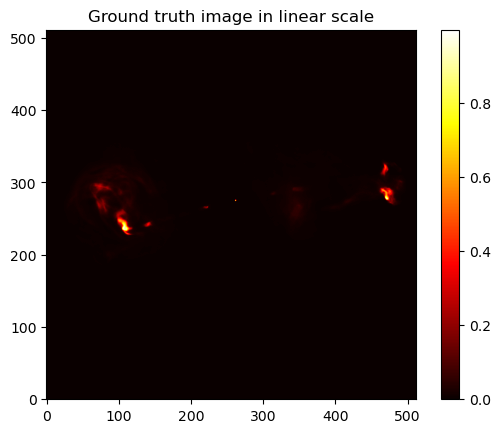

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt

img_gdth = fits.getdata('data/3c353_gdth.fits').astype(float)
plt.imshow(img_gdth, cmap='hot')
plt.title('Ground truth image in linear scale')
plt.gca().invert_yaxis()
plt.colorbar();

Given the large dynamic range of the ground truth, only bright features are visible in linear scale. For a better visualisation, we map its pixels intensities to the logarithmic scale using the equation below [4]:

$$
\textrm{rlog}(x)={x}_{\max} \log_a (\frac{a}{x_{\max}} x+1)\;,
$$

where $a>0$ and $x_{\max}$ are the dynamic range and the maximum intensity of input image $x$ respectively. For the ground truth image ${{\overline{x}}}$ shown above, the maximum intensity is ${\overline{x}}_{\max} =1.0$ and a dynamic range is approximately $a=10^4$.


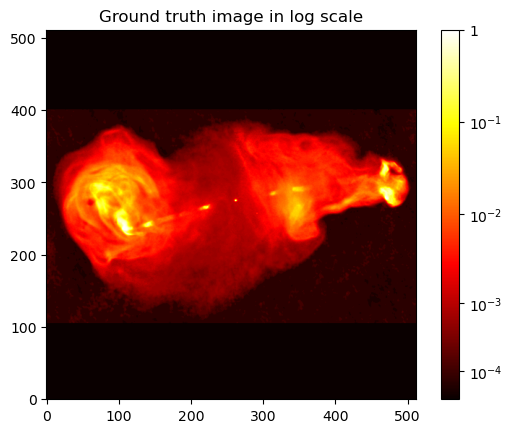

In [3]:
import numpy as np

def rlog(x, a):
    return np.max(x) * np.log10(a * x / np.max(x) + 1.0) / np.log10(a)

dynamic_range = 1e4
img_gdth_log = rlog(img_gdth, dynamic_range)

fig, ax = plt.subplots()
pcm = ax.imshow(img_gdth_log, cmap='hot')
ax.invert_yaxis()
cb = plt.colorbar(pcm, ax=ax)
ticks = [np.log10(dynamic_range * tick + 1)/np.log10(dynamic_range) for tick in [1e-4, 1e-3, 1e-2, 1e-1, 1]]
ticks[-1] = 1
cb.set_ticks(ticks)
cb.set_ticklabels(['$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '1'])
plt.title('Ground truth image in log scale');

The test measurement file in **.mat** associated with the above ground truth can be loaded via the command below.

In [4]:
from scipy.io import loadmat

meas = loadmat('data/3c353_meas_dt_1_seed_0.mat')
for k, v in meas.items():
    if not k.startswith('__'):
        if max(v.shape) == 1:
            if type(v.item()) == str:
                print(f"{k}: {v.item()}")
            else:
                print(f"{k}: {v.item():.4e}")
        else:
            print(f"{k}: {v.shape}, {type(v)}")

frequency: 1.0000e+09
y: (201600, 1), <class 'numpy.ndarray'>
u: (201600, 1), <class 'numpy.ndarray'>
v: (201600, 1), <class 'numpy.ndarray'>
w: (201600, 1), <class 'numpy.ndarray'>
nW: (201600, 1), <class 'numpy.ndarray'>
nWimag: (0, 0), <class 'numpy.ndarray'>
maxProjBaseline: 2.5948e+04


The expected fields are listed below.

   -  `y`:  measurement/data  vector. 
   -  `u`: $u$ coordinates in units of the observation wavelength. 
   -  `v`: $v$ coordinates in units of the observation wavelength. 
   -  `w`: $w$ coordinates in units of the observation of wavelength. 
   -  `nW`:  noise-whitening vector, known as the* natural weights*, corresponding to the* *inverse of the noise standard deviation. During imaging, these weights are applied to the measurements and injected into the measurement operator model. 
   -  `nWimag`: imaging weight vector, compensating for the non-uniform Fourier sampling and enhancing the effective resolution of the observations. The vector is **optional** and can be computed directly in the `AIRI` imager. 
   -  `frequency`:  the observation frequency in Hz. 
   - `maxProjBaseline`: the maximum projected baseline in units of the observation wavelength, formally it equals to ${\mathrm{m}\mathrm{a}\mathrm{x}}\left\lbrace \sqrt{u^2 +v^2 }\right\rbrace$. Hence, it represents **the spatial bandwidth of the Fourier sampling**.

The collection of the $(u,v)$ points constitutes the 2D Fourier sampling pattern also known as the $uv$-coverage.

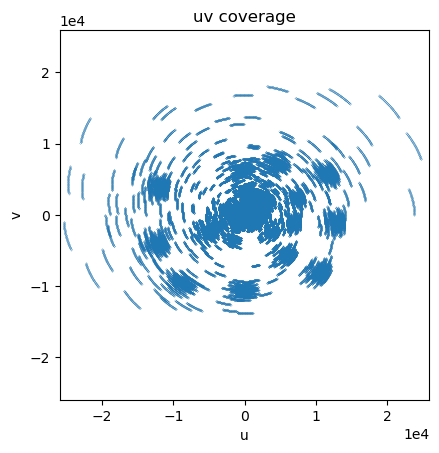

In [5]:
plt.scatter(meas['u'], meas['v'], s=0.01)
plt.axis('square')
plt.xlim(-meas['maxProjBaseline'], meas['maxProjBaseline'])
plt.ylim(-meas['maxProjBaseline'], meas['maxProjBaseline'])
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.xlabel('u')
plt.ylabel('v')
plt.title('uv coverage');

In the context of narrow-field RI, the effect of the $w$ coordinates is negligible, and is therefore not considered in the measurement operator model. 

**Scripts to generate** [**synthetic measurement files**](https://github.com/basp-group/RI-measurement-operator/blob/python/example_sim_ri_data.py) **as well as to convert real** [**Measurement Sets (MS) to .mat files**](https://github.com/basp-group/Small-scale-RI-imaging/blob/main/ms2mat) **readable by this repository are available.**

## Imaging with AIRI

`AIRI` imager is launched via the `Python` script **`run_imager.py`**. It takes as input a configuration file in **`.json`** format, where all parameters involved in the imaging process are defined and set to default values where relevant. The readers are directed to this [README](https://github.com/basp-group/Small-scale-RI-imaging/blob/main/config/README.md) for more information on the content of the configuration file.

For this tutorial, we use the example configuration file `./config/example.json`. The function **`run_imager`** also accepts **optional** name-argument pairs to overwrite corresponding fields in the configuration file. 

The user **must** provide **the target image size** and **the pixel size in arcsecond**, either directly in the configuration file or as input argument parsed to the function **`run_imager`**. When the pixel size is not known, the user can instead specify the ratio between the spatial Fourier bandwidth of the target/ground-truth image and the bandwidth of the Fourier sampling pattern. We refer to this ratio as the **superresolution** factor.  In such case, the pixel size in **arcsecond** is automatically derived from the superresolution factor as: 

$$
imPixelSize=\frac{180\times 3600}{\pi }\times \frac{1}{2\times maxProjBaseline\times superresolution}.
$$

For our test dataset, the reconstructed image size is set to $N=512\times 512$ same as the ground truth, and the pixel size is set such that $superresolution=1.0$ (*i.e.* the spatial bandwidth of the Fourier sampling equals the Fourier bandwidth of the ground-truth/target image). Natural weighting is considered during imaging by default.

We use the `AIRI` denoiser shelf trained with optical astronomical image dataset (OAID shelf). The stopping criteria (*e.g.* the total number of iterations and the bound on relative variation of the estimate across the iterations) are set to default. For faster runtime, the user can consider looser values.

Under these considerations, `AIRI` is launched via the imaging command below. We recommend running `AIRI` fully on NVIDIA GPU for faster reconstruction speed. To do so, the two fields in the configuration file, *i.e.* `meas_device` and `prox_device`, to `"cuda"`. The `AIRI` takes approximately around 3 minutes in total with CUDA acceleration for the example.



In [ ]:
!python run_imager.py -c "./config/example.json" --algorithm "airi" --src_name "example"

## AIRI Results

`AIRI`  imager provides as output both the point spread function and the so-called dirty image (i.e. the normalised back-projected data), saved in **`.fits`** format.

   - The point spread function (PSF) is defined as $h=\kappa {\mathrm{R}\mathrm{e}}\left\lbrace {{\Phi }}^{\dagger} {\Phi }{{\delta }}\right\rbrace$, with ${{\delta }}$ a Dirac delta image (with value 1 at its centre and 0 otherwise), and $\kappa$ a normalisation factor ensuring its peak value is equal to 1.
   - The dirty image (*i.e*. the normalised back-projected data) is defined as $x_d =\kappa {\mathrm{R}\mathrm{e}}\left\lbrace {{\Phi }}^{\dagger} y\right\rbrace$.


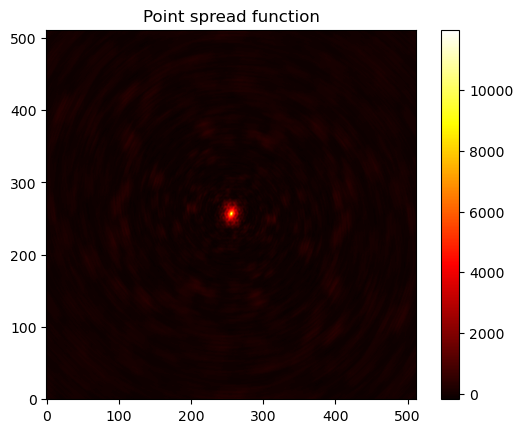

In [6]:
dirty = fits.getdata("./results/example/psf.fits").astype(float)

fig, ax = plt.subplots()
pcm = ax.imshow(dirty, cmap='hot')
ax.invert_yaxis()
cb = plt.colorbar(pcm, ax=ax)
plt.title('Point spread function');

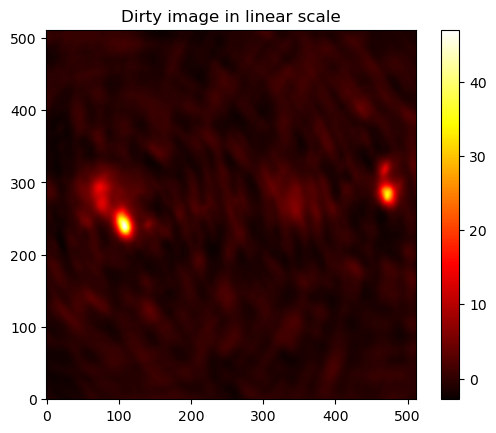

In [7]:
dirty = fits.getdata("./results/example/dirty.fits").astype(float)

fig, ax = plt.subplots()
pcm = ax.imshow(dirty, cmap='hot')
ax.invert_yaxis()
cb = plt.colorbar(pcm, ax=ax)
plt.title('Dirty image in linear scale');

`AIRI` reconstructed images are saved in **`.fits`** format. 

- The estimated model image $\overset{～}{x}$.
- The associated  residual dirty image (i.e. normalised back-projected data residual) $\overset{～}{r} =\kappa \left({\mathrm{R}\mathrm{e}}\left\lbrace {{\Phi }}^{\dagger} y\right\rbrace -{\mathrm{R}\mathrm{e}}\left\lbrace {{\Phi }}^{\dagger} {\Phi }\overset{～}{x} \right\rbrace \right)$.

We use the two metrics below for a quantitative evaluation of the algorithm's performance: 

$$
{\mathrm{S}\mathrm{N}\mathrm{R}}({{\overline{x} }},{{\overset{～}{x} }})=20{{\mathrm{l}\mathrm{o}\mathrm{g}}}_{10} \left(\frac{\|{{\overline{x} }}{\|}_2 }{\|{{\overline{x} }}-{{\overset{～}{x} }}{\|}_2 }\right),
$$

$$
{\mathrm{l}\mathrm{o}\mathrm{g}\mathrm{S}\mathrm{N}\mathrm{R}}\left({{\overline{x} }},{{\overset{～}{x} }}\right)={\mathrm{S}\mathrm{N}\mathrm{R}}\left({\mathrm{r}\mathrm{l}\mathrm{o}\mathrm{g}}({{\overline{x} }}),{\mathrm{r}\mathrm{l}\mathrm{o}\mathrm{g}}({{\overset{～}{x} }})\right).
$$



In [8]:
def snr_rec(im_rec, im_true):
    return 20*np.log10(np.linalg.norm(im_true.flatten()) / np.linalg.norm(im_true.flatten() - im_rec.flatten()))

img_model = fits.getdata("./results/example/AIRI_heuScale_1.0_model_image.fits").astype(float)
airi_snr = snr_rec(img_model, img_gdth)
airi_logsnr = snr_rec(rlog(img_model, dynamic_range), rlog(img_gdth, dynamic_range))

print(f"Reconstruction metrics: SNR {airi_snr:.3f} dB; logSNR {airi_logsnr:.3f} dB")

Reconstruction metrics: SNR 25.281 dB; logSNR 21.010 dB


Note that in [3], we considered a slightly different mapping of the logarithmic scale that is parameterised by the maximum intensity value ${\bar{\mathit{\mathbf{x}}} }_{\max }$ of the ground truth and the estimate of the target dynamic range defined as $\hat{a} =1/\sigma$, such that: 

$$
\textrm{rlog}(\mathit{\mathbf{x}})={\bar{\mathit{\mathbf{x}}} }_{\max } \log_{\hat{a} } (\frac{\hat{a} }{{\bar{\mathit{\mathbf{x}}} }_{\max } }\mathit{\mathbf{x}}+1)\;\ldotp
$$

We report below the value of the resulting logSNR metric, to which we refer to as logSNR2.

In [9]:
def rlog2(x, a):
    return np.log10(a * x / np.max(x) + 1.0) / np.log10(a)

dynamic_range_est = 2500
airi_logsnr2 = snr_rec(rlog2(img_model, dynamic_range_est), rlog2(img_gdth, dynamic_range_est))
print(f"Reconstruction metrics: logSNR2 {airi_logsnr2:.3f} dB")

Reconstruction metrics: logSNR2 23.363 dB


Next, we'll visualise the reconstructed image.

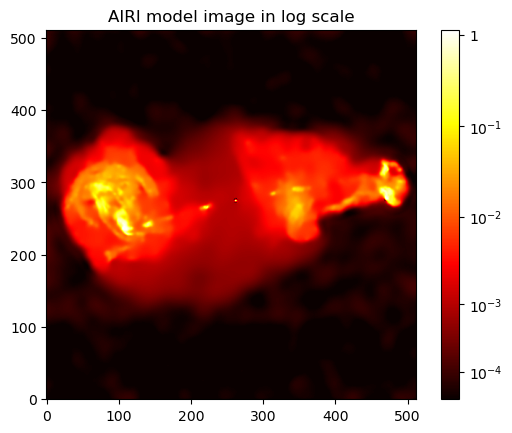

In [10]:
img_model_log = rlog(img_model, dynamic_range)

fig, ax = plt.subplots()
pcm = ax.imshow(img_model_log, cmap='hot')
ax.invert_yaxis()
cb = plt.colorbar(pcm, ax=ax)
ticks = [np.log10(dynamic_range * tick + 1)/np.log10(dynamic_range) for tick in [1e-4, 1e-3, 1e-2, 1e-1, 1]]
ticks[-1] = 1
cb.set_ticks(ticks)
cb.set_ticklabels(['$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '1'])
plt.title('AIRI model image in log scale');

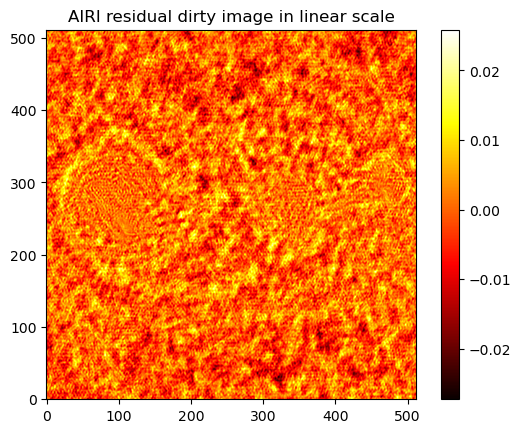

In [11]:
img_residual = fits.getdata("results/example/AIRI_heuScale_1.0_normalised_residual_dirty_image.fits").astype(float)

fig, ax = plt.subplots()
pcm = ax.imshow(img_residual, cmap='hot')
ax.invert_yaxis()
cb = plt.colorbar(pcm, ax=ax)
plt.title('AIRI residual dirty image in linear scale');

## Additional Functionalities

The code supports data-weighting schemes during imaging (uniform or Briggs weighting).  It provides the functionality to compute the imaging weights if not available in the input data file.

The repository also provides implementations of other imaging algorithms, such as `cAIRI` [3] and [`uSARA`](https://github.com/basp-group/Small-scale-RI-imaging/blob/main/tutorial_usara_python.ipynb). We direct the readers to the full [README](https://github.com/basp-group/Small-scale-RI-imaging/blob/main/README.md) of this repository for more information.

## References

   -  [1] Terris, M., Dabbech, A., Tang, C., \& Wiaux, Y., [Image reconstruction algorithms in radio interferometry: From handcrafted to learned regularization denoisers](https://doi.org/10.1093/mnras/stac2672). *MNRAS, 518*(1), 604-622, 2023. 
   -  [2] Wilber, A. G., Dabbech, A., Jackson, A., \& Wiaux, Y., [Scalable precision wide-field imaging in radio interferometry: I. uSARA validated on ASKAP data](https://doi.org/10.1093/mnras/stad1351). *MNRAS, 522*(4), 5558-5575, 2023. 
   -  [3] Terris, M., Tang, C., Jackson, A., \& Wiaux, Y., [The AIRI plug-and-play algorithm for image reconstruction in radio-interferometry: variations and robustness](https://arxiv.org/abs/2312.07137v23), 2023, *preprint arXiv:2312.07137v3.* 
   -  [4] Aghabiglou, A., San Chu, C., Dabbech, A., \& Wiaux, Y., [The R2D2 deep neural network series paradigm for fast precision imaging in radio astronomy](https://doi.org/10.3847/1538-4365/ad46f5). ApJS*, 273*(1), 3, 2024.
